### MobileNetV1

A MobileNetV1 foi apresentada pelo Google. Ela foi projetada para dispositivos móveis e embarcados, onde recursos computacionais como processamento e memória são limitados. Para conseguir esta eficiência, a rede utiliza convoluções separáveis por profundidade ao invés da convolução padrão encontrada em redes CNN.

Considere a entrada da rede uma foto de 224x224 pixels e 3 canais de cor. A MobileNetV1 utilizará da convolução separável por profundidade e esta é feita em duas partes: convolução por profundidade (depthwise convolution) e convolu~çao pontual (pointwise convolution). Veja como é cada uma delas:

- depthwise convolution: ao invés de usar um único filtro para processar os três canais, neste tipo de convolução teremos um filtro separado para cada canal. Como a imagem tem 3 canais, teremos 3 filtros diferentes, um para cada canal. Isso reduz drasticamente o número de cálculos
- pointwise convolution: 

In [1]:
import torch 
import torch.nn as nn


from IPython.display import Image

import torchvision
from torchview import draw_graph

device = torch.device('cpu')


In [2]:
from graphviz import Digraph

dot = Digraph()
dot.attr(fontname="Arial")

torch.Size([1, 64, 56, 56])



(process:6160): Pango-WARNING **: 11:09:43.297: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:912): Pango-WARNING **: 11:09:43.527: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


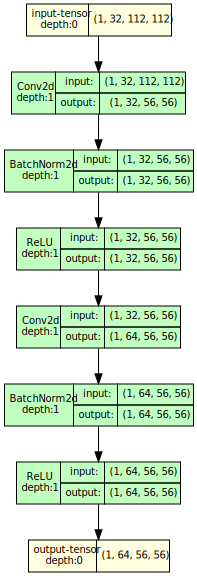

In [3]:
class  DepthWiseSeperable (nn.Module): 

    def  __init__ ( self, in_channels, out_channels, stride ): 
        """ 
        Bloco DepthWiseSeperable do MobileNet que realiza as seguintes operações: 
        (a) convolução em profundidade aplicando um filtro separado para cada canal 
        (b) convoluções pontuais são aplicadas, combinando o resultado filtrado implementando a convolução 1 × 1 
        
            Nota: 
                1. groups = in_channels usados ​​para convolução em profundidade 
                2. in_channels e out_channels são os mesmos para convolução em profundidade 
                3. bias = False devido ao uso de BatchNorm 
                4. Para gerar a mesma altura e largura do mapa de recursos de saída que o mapa de recursos de entrada, o seguinte deve ser o preenchimento para 
                    * 1x1 conv: p=0 
                    * 3x3 conv: p=1 
                    * 5x5 conv: p=2 


        Argumentos: 
          in_channels (int): número de canais de entrada 
          out_channels (int) : número de canais de saída 
          stride (int) : stride usado para convolução em profundidade 

        Atributos: 
            Bloco convolucional separável em profundidade 

        """ 

        super (DepthWiseSeperable,self).__init__() 
        
        # grupos usados ​​aqui
        self.depthwise = nn.Conv2d(in_channels = in_channels , out_channels = in_channels , stride = stride , padding = 1 , kernel_size = 3 , groups=in_channels , bias = False ) 
        self.bn1 = nn.BatchNorm2d(in_channels) 

        self.pointwise = nn.Conv2d(in_channels = in_channels , out_channels = out_channels , stride = 1 , padding = 0 , kernel_size = 1 , bias = False ) 
        self.bn2 = nn.BatchNorm2d(out_channels) 

        self.relu = nn.ReLU() 

    def  forward ( self,x ): 

        x = self.depthwise(x) 
        x = self.bn1(x) 
        x = self.relu(x) 
        
        x = self.pointwise(x) 
        x = self.bn2(x) 
        x = self.relu(x) 
        
        return x 


def  test_DepthWiseSeperable (): 
    x = torch.randn( 1 , 32 , 112 , 112 ) 
    model = DepthWiseSeperable( 32 , 64 , 2 ) 
    print (model(x).shape)

    return model


modelo = test_DepthWiseSeperable() 
arquitetura = 'DepthWiseSeperable'
model_graph = draw_graph(modelo, input_size=( 1 , 32 , 112 , 112 ), graph_dir = 'TB' , roll= True , expand_nested= True , graph_name= f'self_ {arquitetura} ' ,save_graph= True ,filename= f'self_ {arquitetura} ' ) 
model_graph.visual_graph 

torch.Size([1, 1000])



(process:9952): Pango-WARNING **: 11:09:44.465: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:15128): Pango-WARNING **: 11:09:45.073: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


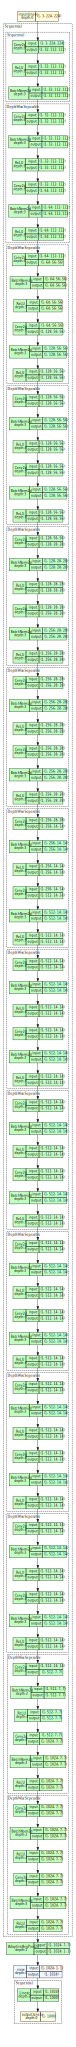

In [4]:
class MobileNetV1(nn.Module):
    
    def __init__(self, num_classes=1000):
        
        super(MobileNetV1, self).__init__()

        # Camada de convolução inicial
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
        )
        
        # Convoluções separáveis em profundidade
        self.features = nn.Sequential(
            self.features,
            DepthWiseSeperable(32, 64, 1),
            DepthWiseSeperable(64, 128, 2),
            DepthWiseSeperable(128, 128, 1),
            DepthWiseSeperable(128, 256, 2),
            DepthWiseSeperable(256, 256, 1),
            DepthWiseSeperable(256, 512, 2),
            
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),

            DepthWiseSeperable(512, 1024, 2),
            DepthWiseSeperable(1024, 1024, 1)

        )
        
        # Average pooling e classificador
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Criar uma instância da MobileNetV1
model = MobileNetV1()
# print(model)


def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


model = test_Mobilenet()
architecture = 'mobilenetv1'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

In [6]:
# usar o summary para obter uma visão geral da arquitetura
from torchsummary import summary
summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
              ReLU-2         [-1, 32, 112, 112]               0
       BatchNorm2d-3         [-1, 32, 112, 112]              64
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]           2,048
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
DepthWiseSeperable-10         [-1, 64, 112, 112]               0
           Conv2d-11           [-1, 64, 56, 56]             576
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128